<a href="https://colab.research.google.com/github/Hepheir/Korean-artifact-breakage-detection/blob/master/%EC%84%B8%EB%AF%B8%EB%82%98_%EA%B9%80%EB%8F%99%EC%A3%BC%2C%EC%9D%B4%EB%8F%84%EA%B2%BD_20200716_%EA%B8%B0%EC%99%80%EA%B2%80%EC%B6%9C_(%EC%97%B0%EA%B2%B0%EC%95%B1_Google_Colaboratory%EB%A1%9C_%EC%97%B4%EA%B8%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기와 검출

> <-- **좌측 상단에 '목차' 기능을 이용하면 간편하게 문서 열람이 가능합니다.**

---

| 참여 연구원 | 소속 | 연락처 |
| --- | --- | --- |
| 김동주 | 동국대학교 경주캠퍼스 | hepheir@gmail.com |
| 이도경 | 동국대학교 경주캠퍼스 | ike155@naver.com |

## 요약

본 문서에서는 기와의 파손 검사를 위한 딥러닝 모델을 학습시키기 위한 데이터셋을 생성하기 위한 아이디어를 보인다.
(미완성)

---

## 의존성

| Type | Name | Version | Site |
| --- | --- | --- | -- |
| OS | Windows | 10 |  |
| Language | Python | 3.7.7 | https://www.python.org/ |
| Dev env. | Anaconda | * | https://docs.anaconda.com/anaconda/ |
| pip module | tensorflow-gpu | 2.2.0 | https://www.tensorflow.org/ |
| pip module | numpy | 1.19.0 | https://numpy.org/ |
| pip module | opencv-python | 4.3.0.36 | https://opencv.org/ |
| pip module | scipy | 1.4.1 | https://scipy.org/ |

<!-- table row 양식

| Type | Name | Version | Install |

| pip module |  |  |  |

-->

In [ ]:
#@title Imports {display-mode: "form"}

import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.signal

from mpl_toolkits.mplot3d import Axes3D

import urllib.request
import collections

---

# 1. 개요

기와를 한 장씩 독립적으로 추출할 수 있다면, 각 기와 타일에 대한 파손 상황을 검사하여 레이블을 붙임으로서 데이터 셋을 쉽게 생성할 수 있을 것이다.

데이터 셋을 생성하기 위해서는 기와 데이터를 정규화 시킬 필요가 있다. 이 전처리 과정을 설계해보자.

> 전처리: 기와 영상의 보정 작업 및 정규화

---

## 1.1 용어 정리

작업에 앞서, 혼동을 피하고자 기와의 각 부분을 명칭하는 용어를 먼저 알아본다.

![기와 용어](https://t1.daumcdn.net/cfile/blog/146D203B4D4892B830)

---

# 2. 데이터 살펴보기

사용할 기와 영상들은 대부분 [*리하이의 드론*에 의해 촬영된 영상](https://drive.google.com/drive/folders/1Hfwn8X9SEt96GJ_iuk8ZaEPWYt5pLvQm)으로 기대된다.

 > 촬영된 영상들은 소실점을 갖는 이미지 일 것이다.

왜곡된 이미지로 부터 데이터 셋 생성이 어렵다.

> 소실점을 갖는 이미지는 회전 혹은 왜곡을 포함하고 있기에, 기와를 한 장씩만 포함하는 영상으로 자르기가 매우 어렵다.

전처리 과정. 즉, 드론촬영에 의한 기와 영상의 보정과정이 필요하다.


---

## 2.1 이미지 준비하기

본 실험에서 사용할 이미지를 준비한다.

---
### 2.1.1 Image Class

한 번 다운로드 한 영상을 여러번 사용하다보면, 원본이 훼손되거나 손실이 일어날 수 있다.

보다 안정적으로 이미지를 다루기 위해 Image를 담을 클래스를 생성하여 사용한다.

In [ ]:
#@title Image()

class Image:
    """
    실험에 사용할 이미지를 안정적으로 다루기 위해 만든 클래스
    """

    def __init__(self, frame=None):
        self.__frame = None
        self.isSingleChannel = False
        self.frame = frame

    def download_image(self, url):
        """
        주어진 url로 부터 이미지를 다운받아 numpy.ndarray 형태로 저장합니다.
        @param url : str, 다운로드 할 이미지의 url
        """
        print('Opening request', end='')
        xhr = urllib.request.urlopen(url)
        print('\rDownloading image...', end='')
        frame = xhr.read()
        print('\rParsing image...', end='')
        frame = np.asarray(bytearray(frame), dtype=np.uint8)
        frame = cv2.imdecode(frame, cv2.IMREAD_COLOR)

        if frame is None:
            raise NoImageError("Could not download the image.")

        self.frame = frame
        print('\rDownload Complete')

    @property
    def frame(self):
        if self.__frame is None:
            raise NoImageError("No frame")
        return self.__frame

    @frame.setter
    def frame(self, new_frame):
        if new_frame is not None:
            self.__frame = new_frame
            self.height = new_frame.shape[0]
            self.width = new_frame.shape[1]
            self.shape = new_frame.shape
            self.dtype = new_frame.dtype
            self.isSingleChannel = len(new_frame.shape) == 2

    @property
    def rgb(self):
        return cv2.cvtColor(self.frame, cv2.COLOR_BGR2RGB)

    @property
    def gray(self):
        return cv2.cvtColor(self.frame, cv2.COLOR_BGR2GRAY)

class NoImageError(Exception):
    pass

---

### 2.1.2 샘플 이미지 다운로드 (실험군)

In [ ]:
#@title 실험군 이미지 다운로드 예제 {display-mode: "form"}

sample_image_url = "https://github.com/Hepheir/Korean-artifact-breakage-detection/blob/Experiments-for-Giwa-Detection/Giwa(roof-tile)/resources/clean/DJI_0007.JPG?raw=true" #@param {type:"string"}

sample_image = Image()
sample_image.download_image(sample_image_url)

plt.figure(figsize=(16,9))
plt.imshow(sample_image.rgb)
plt.title('Downloaded Image')
plt.show()

---

### 2.1.3 샘플 이미지 다운로드 2 (대조군)

모델의 설계과정에서 일반화 성능을 충분히 고려할 수 있도록 대조군을 준비하여 사용한다.

본 실험에서는 주어진 기와영상으로 부터 데이터 해석만 하기에, 기와 영역 부분만 추출하여 사용하도록 영상의 일부만 추출하여 사용하도록 한다..

In [ ]:
#@title 대조군 이미지 다운로드 예제 {display-mode: "form"}

control_image_url = "https://github.com/Hepheir/Korean-artifact-breakage-detection/blob/Experiments-for-Giwa-Detection/Giwa(roof-tile)/resources/clean/DJI_0004.JPG?raw=true" #@param {type:"string"}

control_image = Image()
control_image.download_image(control_image_url)

plt.figure(figsize=(16,9))
plt.imshow(control_image.rgb)
plt.title('Downloaded Image')
plt.show()

In [ ]:
#@title 대조군 이미지의 일부만 추출 예제 {display-mode: "form"}

startX, startY = 250, 200
endX, endY = 4500, 3500

# 추출할 영역을 보여준다.
rgb = control_image.rgb

cv2.rectangle(rgb, (startX, startY), (endX, endY), (255,0,0), 4)
plt.figure(figsize=(16,12))
plt.imshow(rgb)
plt.title('Cropped Area')
plt.show()

control_image.frame = control_image.frame[startY:endY,startX:endX]

---

## 2.2 컴퓨터와 인간의 시각 차이

> 인간과 달리 컴퓨터는 착시를 겪지 않는다.

우리가 보기엔 다음의 정보를 쉽게 판단 할 수 있다.

1. 기와의 표면의 형태 (둥근 형태).
2. 광원이 어느 방향에 있는지. (태양빛이 동쪽위에서 서쪽아래로 향한다.)

사람은 착시를 통해 정보를 해석할 수 있다. 평평한 영상으로 부터 입체적인 정보를 유추해낼 수 있는 사람과 달리 컴퓨터는 그렇지 못하다.

---

## 2.3 데이터로써의 이미지 보기

---

### 2.3.1 하나의 행

2차원 그래프에서 이미지의 최상단, y좌표가 0인 한 줄을 출력했을 때를 본다.

In [ ]:
#@title 단일 행 출력 예제 {display-mode: "form"}

def plot_single_row(image, y):
    extracted_line = image.gray[y,:]
    # Draw guide line
    rgb = image.rgb
    cv2.line(rgb, (0,y), (image.width,y), (255,0,0), 8)
    # Plot
    fig = plt.figure(figsize=(12,15))
    gs = mpl.gridspec.GridSpec(
        nrows=2,
        ncols=1,
        height_ratios=[3,2],
        width_ratios=[1]
    )
    plt.subplot(gs[0]).imshow(rgb)
    plt.subplot(gs[1]).plot(extracted_line)
    plt.show()

y = 176 #@param {type:"slider", min:0, max:1000, step:1}
plot_single_row(sample_image, y)

---
### 2.3.2 밝기를 z축상에 놓은 3차원 이미지

3차원 그래프에서 x, y좌표는 그대로 적용, 이미지의 각 픽셀의 밝기정보를 z축상에 표현한다고 하면 이미지가 어떻게 보이는지를 한번 보자.

Successfully plotted 3D data


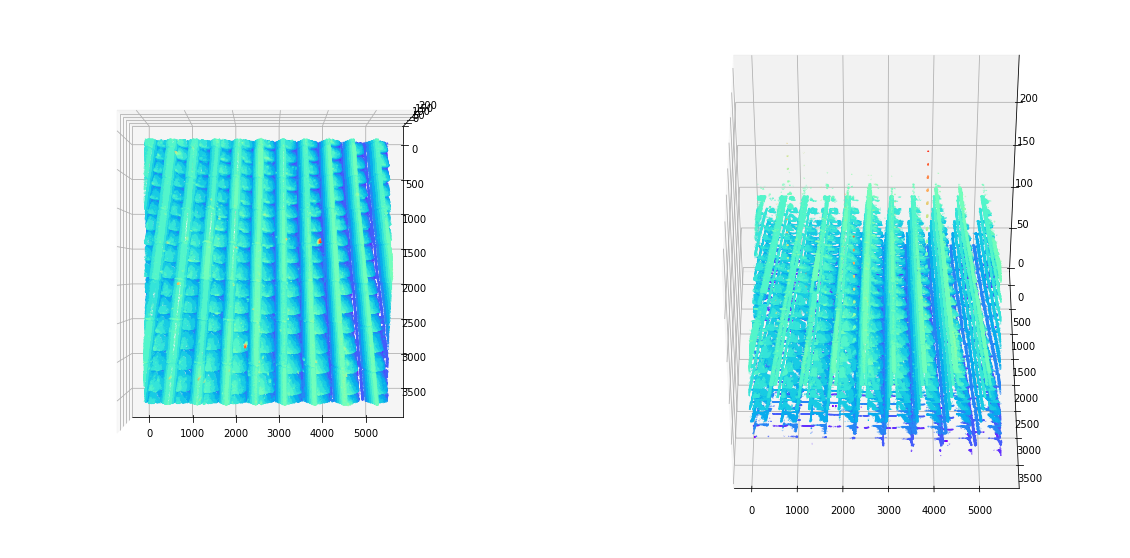

In [ ]:
#@title 3D Graphed Image 예제 {display-mode: "form"}

enable_plot_3D = True #@param ["True", "False"] {type:"raw"}

def plot_3d(image):
    """
    single-channel 이미지를 3d 그래프 상에 출력한다.
    z축의 값으로는 밝기 값을 사용한다.
    @param image : single-channel image (np.ndarray)
    """
    if not isinstance(image, Image):
        raise TypeError(f'{image} is not an instance of {Image}')

    if not enable_plot_3D:
        print('3D plotting disabled')
        return

    # Make 3D plot-able data
    print('Make 3D data plot-able', end='')
    x = np.linspace(0, image.width, image.width)
    y = np.linspace(0, image.height, image.height)
    x, y = np.meshgrid(x, y)
    z = image.gray
    # Plotting
    print('\rCreate Figure', end='')
    fig = plt.figure(figsize=(20,10))
    gs = mpl.gridspec.GridSpec(
        nrows=1,
        ncols=2,
        height_ratios=[1],
        width_ratios=[1,1]
    )
    print('\rPlotting TOP-View (1/2)', end='')
    # TOP VIEW
    ax = plt.subplot(gs[0], projection='3d')
    ax.contour3D(x, y, z, 20, cmap=plt.cm.rainbow)
    ax.view_init(elev=90, azim=90) # 방향 돌려서 보기.
    plt.gca().invert_xaxis()
    print('\rPlotting 45 degree View (2/2)', end='')
    # 45-ROLLED (x축에 대하여 45도 회전시킴)
    ax = plt.subplot(gs[1], projection='3d')
    ax.contour3D(x, y, z, 20, cmap=plt.cm.rainbow)
    ax.view_init(elev=45, azim=90)
    plt.gca().invert_xaxis()
    print('\rPlotting results', end='')
    plt.show()
    print('\rSuccessfully plotted 3D data')

plot_3d(sample_image)

---

## 2.4 데이터로서의 이미지 분석

3D 형태로 출력된 그래프를 보면 일정한 간격을 두고, 송곳 모양 패턴이 반복되고 있음을 알 수 있으며, 패턴의 간격은 암기와와 숫기와가 반복되는 간격과 일치한다고 볼 수 있다.

이 간격을 파악할 수 있다면, 기와 영상을 쉽게 보정 할 수 있을 것이다.



---

# 3. 직선 검출

*2.2 데이터 살펴보기* 과정을 통해 암기와-숫기와가 반복되는 패턴을 파악하여 영상을 보정 할 수 있음을 유추 할 수 있었다.

**직선 검출을 위한 Fuzzy한 모델을 설계하고, 이를 일반화 할 수 있도록 해보자.**

> 용어 정리: [Fuzzy (퍼지 논리)](https://ko.wikipedia.org/wiki/%ED%8D%BC%EC%A7%80_%EB%85%BC%EB%A6%AC) : 참, 거짓과 같이 이진 논리로 표현하는 것이 어려운 불분명한 상태, 모호한 상태를 표현하는 논리 개념



---

## 3.1 임계처리

임계 처리를 통하여 그래프 상에서 반복되는 패턴의 주기를 구하려고 시도한다.

---

### 3.1.1 그래프 분석

최상단 한 줄을 이용하여, 임계처리를 위해 어떠한 방법을 사용할 수 있을 지 알아본다.

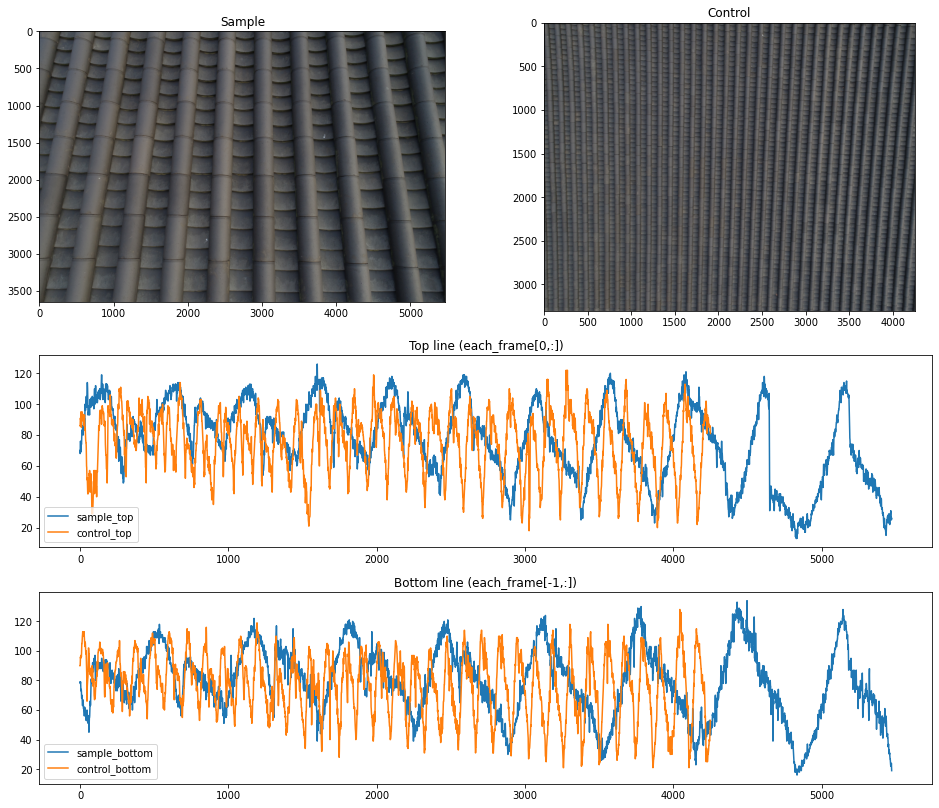

In [ ]:
#@title 정규화 되지 않은 그래프 예제 {display-mode: "form"}

def before_normalize():
    plt.figure(figsize=(16, 14))
    gs = mpl.gridspec.GridSpec(
        nrows=3, ncols=2,
        height_ratios=[6,4,4],
        width_ratios=[1,1]
        )
    # Sample Image
    ax = plt.subplot(gs[0,0])
    ax.imshow(sample_image.rgb)
    ax.title.set_text('Sample')
    # Control Image
    ax = plt.subplot(gs[0,1])
    ax.imshow(control_image.rgb)
    ax.title.set_text('Control')
    # Top Lines
    ax = plt.subplot(gs[1,:])
    ax.plot(sample_image.gray[0], label='sample_top') # 실험군 1
    ax.plot(control_image.gray[0], label='control_top') # 대조군 1
    ax.legend()
    ax.title.set_text('Top line (each_frame[0,:])')
    # Bottom Lines
    ax = plt.subplot(gs[2,:])
    ax.plot(sample_image.gray[-1], label='sample_bottom') # 실험군 2
    ax.plot(control_image.gray[-1], label='control_bottom') # 대조군 2
    ax.legend()
    ax.title.set_text('Bottom line (each_frame[-1,:])')
    plt.show()

before_normalize()

---

### 3.1.2 정규화

위 그래프를 보면, 그래프 y축(밝기)의 분포가 대략 10\~130 에서 이루어 지고 있는 것을 알 수 있다.

영상을 촬영하다보면 주변 조도에 의해 영상의 밝기가 변화할 수 있다.

* 즉, 그래프의 분포가 어떠할 땐 10\~130 범위에 있고, 또 어떨땐 180\~244 일 수도 있다는 것이다.

**일반화가 용이하도록 이를 정규화 하는 과정을 거친다.**

* 정규화를 통해 어떠한 입력에 대해서도 값을 **0.0 \~ 1.0 사이**의 동일한 범위내로 조정한다.
* 정규화를 통해 설계모델이 다양한 데이터에 대해 일관성을 가지도록 한다.

In [ ]:
def normalize(array):
    """
    일반화 성능을 높이기 위하여 스캐일을 0~1사이의 값으로 적절히 조절한다.
    @param lane : 1-D array
    """
    maxval = max(array)
    minval = min(array)
    distance = maxval-minval
    array = array - minval
    array = array / distance
    return array

AttributeError: ignored

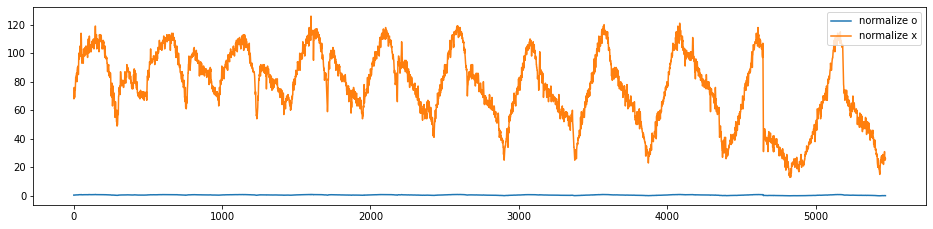

In [ ]:
#@title 정규화 된 그래프 예제 {display-mode: "form"}

def after_normalize(image, y):
    extracted_line = image.gray[y]
    normalized_line = normalize(extracted_line)

    # ================================================================
    # Matplotlib를 이용하여 출력
    # ================================================================
    plt.figure(figsize=(16, 8))
    gs = mpl.gridspec.GridSpec(nrows=2, ncols=1)

    # 정규화 전/후 비교
    ax = plt.subplot(gs[0])
    ax.plot(normalized_line, label='normalize o')
    ax.plot(extracted_line, label='normalize x')
    ax.legend()
    ax.set_ylim([0, 255])
    ax.title.set_text('Both Before/After Normalization')

    # 정규화 된 선만 표시
    ax = plt.subplot(gs[1])
    ax.plot(normalized_line)
    ax.title.set_text('Normalized line only')
    ax.set_ylim([0.0, 1.0])

    plt.show()

after_normalize(sample_image, 0)

---

### 3.1.3 임계 처리

*3.1.2 정규화* 과정을 통해 얻은 그래프에서 어떠한 값을 기준으로 임계처리를 하면 패턴의 간격을 구할 수 있을 지 알아본다.



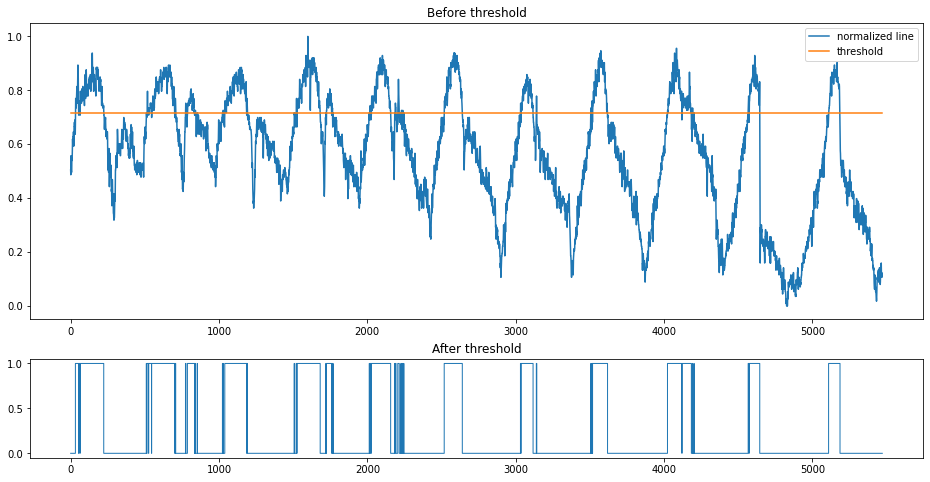

In [ ]:
#@title 임계 처리 예제 {display-mode: "form"}

def simple_threshold(image, threshold):
    extracted_line = image.gray[0]
    normalized_line = normalize(extracted_line)

    step = np.zeros(normalized_line.shape, dtype=float)
    step[normalized_line > threshold] = 1.0

    # ================================================================
    # Matplotlib를 이용하여 출력
    # ================================================================
    plt.figure(figsize=(16,8))
    gs = mpl.gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3,1])

    # Threshold 값을 직관적으로 보기 위해 출력
    ax = plt.subplot(gs[0])
    ax.plot(normalized_line, label='normalized line')
    ax.plot([0, image.width], [threshold, threshold], label='threshold')
    ax.legend()
    ax.title.set_text('Before threshold')

    # Threshold 된 그래프를 step 형식으로 출력 (디지털)
    ax = plt.subplot(gs[1])
    ax.step(range(image.width), step, linewidth=1)
    ax.title.set_text('After threshold')

    plt.show()

threshold = 0.714 #@param {type:"slider", min:0, max:1, step:0.001}

simple_threshold(sample_image, threshold)

---

### 3.1.4 분석

*3.1.3 임계 처리* 에서 얻은 그래프를 보면, 그래프 값의 변동폭이 일정하지 않고 잡음을 많이 포함하고 있어 구간이 일정하지 않고, 깔끔하지 않게 나뉘어졌다.

<!-- Data is not clean. -->


---

## 3.2 잡음 제거

> *3.1 임계처리* 에서 얻은 결과는 그리 만족스럽지 않았다.

우선 그래프로부터 잡음을 제거 해야할 필요성이 있다.

---

### 3.2.1 Numpy 내장 window

Numpy에서 기본적으로 제공하는 window(1-d array)가 몇가지 있다.

In [ ]:
#@title Numpy built-in windows {display-mode: "form"}

size = 100
plt.figure(figsize=(16,6))
plt.plot(np.blackman(size), label='blackman')
plt.plot(np.bartlett(size), label='bartlett')
plt.plot(np.hanning(size), label='hanning')
plt.plot(np.hamming(size), label='hamming')
plt.legend()
plt.show()

---
### 3.2.2 Numpy를 이용 잡음제거

[참고 링크](https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html)에 있는 함수를 조금 수정하여 사용한다.


In [ ]:
#@title smooth()

def smooth(x,window_size=11,window=np.blackman, iterations=1):
    """입력된 1차원 배열 x에 대하여, 지정된 윈도우를 이용한 smoothing 작업을 한다."""
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_size:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_size < 3:
        return x
    
    w = window(window_size)
    y = np.convolve(w/w.sum(), x, mode='same')

    iterations -= 1
    if iterations < 1:
        return y
    else:
        return smooth(y, window_size=window_size, window=window, iterations=iterations)


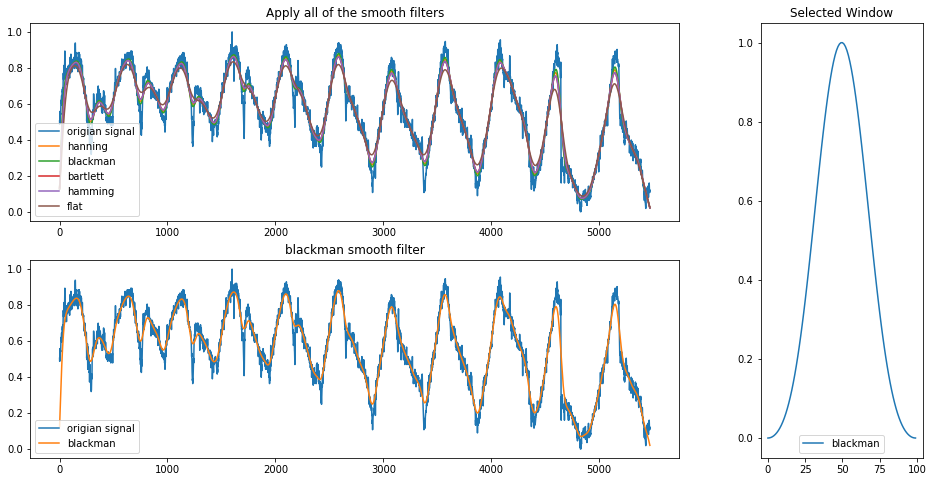

In [ ]:
#@title smooth()를 적용한 예제 {display-mode: "form"}

windows = {
    'hanning' : np.hanning,
    'blackman' : np.blackman,
    'bartlett' : np.bartlett,
    'hamming' : np.hamming,
    'flat' : np.ones
}

# ================================================================
# 예제에 사용될 인자들의 값 입력
# ================================================================
image = sample_image #@param ["sample_image", "control_image"] {type:"raw"}
selected_window_type = 'blackman' #@param ['hanning', 'blackman', 'bartlett', 'hamming', 'flat'] {type:"string"}
window_size = 51 #@param {type:"integer"}
iterations =  10 #@param {type:"integer"}

# ================================================================
# 전처리 (단일 행 추출 및 정규화)
# ================================================================
extracted_line = image.gray[0]
normalized_line = normalize(extracted_line)

# ================================================================
# Matplotlib를 이용하여 출력
# ================================================================
plt.figure(figsize=(16,8))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[4,1])

# 지금 사용하는 window
ax = plt.subplot(gs[:,1])
ax.plot(windows[selected_window_type](100), label=selected_window_type)
ax.legend()
ax.title.set_text('Selected Window')

# 각 smooth window를 모두 적용하여 비교
ax = plt.subplot(gs[0,0])
ax.plot(normalized_line, label='origian signal')
for window_type in windows:
    ax.plot(
        smooth(
            normalized_line,
            window_size=window_size,
            window=windows[window_type],
            iterations=iterations
        ),
        label=window_type
    )
ax.legend()
ax.title.set_text('Apply all of the smooth filters')

# 선택한 하나의 smooth window만 적용
ax = plt.subplot(gs[1,0])
ax.plot(normalized_line, label='origian signal')
ax.plot(
    smooth(
        normalized_line,
        window_size=window_size,
        window=windows[selected_window_type],
        iterations=iterations
    ),
    label=selected_window_type
)
ax.legend()
ax.title.set_text(f'{selected_window_type} smooth filter')

plt.show()

---
## 3.3 피크 점 찾기

*3.2 잡음 제거* 에서 얻은 결과에서 Peak점을 찾아 표시해본다면, 암기와/숫기와가 나열된 방향을 유추하는데 큰 도움이 될 것이라 생각된다.

몇가지 실험을 통해 알아보기로 하였다.

> `scipy`의 신호처리 모듈 `scipy.signal`에서 `find_peaks`라는 함수를 제공한다. 이 기능을 통해 간단하게 peak점들을 찾아내보려 한다.

---
### 3.3.1 scipy.signal.find_peaks()

scipy 모듈에서 제공하는 [`find_peaks()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks) 메소드는 몇가지 유용한 기능들을 제공한다.

* 피크간 최소 거리 간격
* 피크의 최소, 최대 범위 지정

다음은 `scipy.signal.find_peaks()`를 이용하여 찾은 peak들을 이미지 상에 산점도 형태로 출력하는 예제이다.

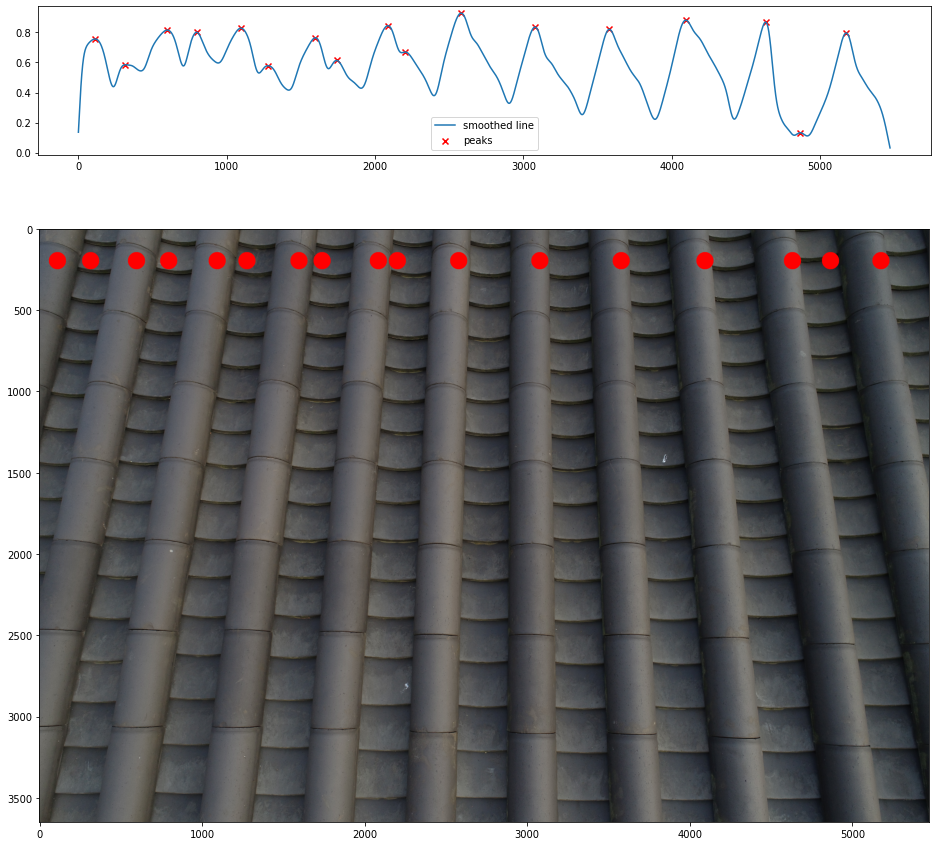

In [ ]:
#@title find_peaks() 를 이용한 예제 {display-mode: "form"} 

# ================================================================
# 예제에 사용될 인자들의 값 입력
# ================================================================
image = sample_image #@param ["sample_image", "control_image"] {type:"raw"}
window_size = 51 #@param {type:"integer"}
iterations =  9 #@param {type:"integer"}
y = 200 #@param {type:"integer"}

# ================================================================
# Peak 찾기
# ================================================================
extracted_line = image.gray[y]
normalized_line = normalize(extracted_line)
smoothed_line = smooth(normalized_line, window_size=window_size, iterations=iterations)

peaks_x, propertise = scipy.signal.find_peaks(smoothed_line)
peaks_y = smoothed_line[peaks_x]

# ================================================================
# Matplotlib를 이용하여 출력
# ================================================================
plt.figure(figsize=(16,15))
gs = mpl.gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[1,4])

# Peak 그래프 출력
ax = plt.subplot(gs[0])
ax.plot(smoothed_line, label='smoothed line')
ax.scatter(peaks_x, peaks_y, label='peaks', marker='x', color='r')
ax.legend()

# 이미지 상에 표시된 Peak 출력
rgb = image.rgb
dot_radius = image.width // (6 * len(peaks_x)) # auto calculated
for x in peaks_x:
    cv2.circle(rgb, (x,y), dot_radius, (255,0,0), -1)
plt.subplot(gs[1]).imshow(rgb)

plt.show()

---
## 3.4 기와 열의 왜곡 파악

Mask created.


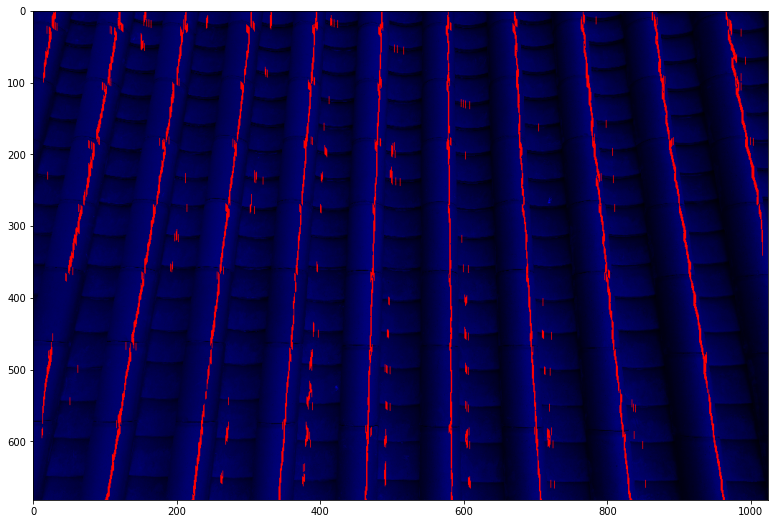

In [ ]:
#@title 모든 행에 대한 Peak를 검사하여 마스크 생성하는 예제 {display-mode: "form"}

image = sample_image #@param ["sample_image", "control_image"] {type:"raw"}
window_size = 16 #@param {type:"integer"}
iterations =  5 #@param {type:"integer"}

# --------
gray = image.gray

# 1. 원본이미지가 너무 큰 관계로, 적절한 크기로 축소
dsize = (1024, image.height * 1024 // image.width)
resized_image = Image(cv2.resize(image.frame, dsize))
gray = resized_image.gray

# 2. 축소된 이미지의 마스크 생성
mask = np.zeros(resized_image.shape[:2], dtype=np.uint8)

for y in range(resized_image.height):
    print(f'\r{y}/{resized_image.height}', end='')
    normalized_line = normalize(gray[y])
    smoothed_line = smooth(normalized_line, window_size=window_size, iterations=iterations)
    peaks_x, propertise = scipy.signal.find_peaks(smoothed_line)
    peaks_y = smoothed_line[peaks_x]
    for x, val in zip(peaks_x, peaks_y):
        mask[y,x] = 255 * val
        # val 은 normalized 된 이미지에서 가져오므로 0.0~1.0의 범위를 가짐.
        # peak의 height과 비례하므로, 더 밝은 peak 가 더 높은 가중치를 가짐.
        # (= 숫기와일 가능성이 더 높은 peak)

print('\rMask created.')

# 3. 마스크 이미지 후처리
#    실험 결과를 더 확연히 볼 수 있도록 모폴로지-팽창 연산 적용
mask = cv2.dilate(mask, (5,5), iterations=10)
mask = cv2.threshold(mask, 0.75*255, 255, cv2.THRESH_BINARY)[-1]

# 4. 결과 출력
result = np.zeros(resized_image.shape, dtype=np.uint8)
result[:,:,2] = gray # 원본이미지를 Blue 영역에 출력
result[mask > 0.0] = (255,0,0) # 마스크가 있는 영역은 붉은색 처리

plt.figure(figsize=(16,9))
plt.imshow(result)
plt.show()

---
# 이 위까지 김동주 변경사항 (last editted: 07/17 19:00)
---

In [ ]:
pallete = mask.copy()

lines = cv2.HoughLines(mask, 0.8, np.pi/180, 100, 1000, 0)

scale = pallete.shape[0] + pallete.shape[1]

for i in lines:
    rho, theta = i[0][0], i[0][1]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a*rho, b*rho


    x1 = int(x0 + scale * -b)
    y1 = int(y0 + scale * a)
    x2 = int(x0 - scale * -b)
    y2 = int(y0 - scale * a)

    cv2.line(pallete, (x1, y1), (x2, y2),255, 10)

plt.figure(figsize=(16,9))
plt.imshow(pallete, cmap='gray')
plt.show()

error: ignored

In [ ]:
kernel = np.array([
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 0]
], dtype=np.uint8)

denoised_mask = cv2.dilate(mask, kernel, iterations=1)
added = cv2.addWeighted(resized_image.gray, 0.8, denoised_mask, 0.7, 0)
plt.figure(figsize=(16,9))
plt.imshow(added, cmap='gray')
plt.show()

areas = map(cv2.contourArea, contours)
areas = sorted(areas)
plt.figure(figsize=(16,9))
plt.step(range(len(areas)), areas)
plt.show()

In [ ]:
pallete = np.zeros(resized_image.shape[:-1], dtype=resized_image.dtype)
contours, hierarchy = cv2.findContours(denoised_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    if cv2.contourArea(cnt) > 3000:
        cv2.drawContours(pallete, [cnt], -1, 128, -1)
        vx,vy,x,y = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
        
        cv2.line(pallete, (x-vx*1000, y-vy*1000), (x+vx*1000, y+vy*1000), 255, 10)
        
plt.figure(figsize=(16,9))
plt.imshow(pallete, cmap='gray')
plt.show()

In [ ]:

gray = image.gray

x_lt, x_rt = 800, 4600
x_lb, x_rb = 150, 5200

before_points = np.array([
    [[x_lt, 0], [x_rt, 0], [x_lb, image.height], [x_rb, image.height]]
], dtype=np.float32)

after_points = np.array([
    [[0, 0], [image.width, 0], [0, image.height], [image.width, image.height]]
], dtype=np.float32)

M = cv2.getPerspectiveTransform(before_points, after_points)
warped = cv2.warpPerspective(gray, M, (image.width, image.height))

plt.figure(figsize=(16,9))
plt.imshow(gray, cmap='gray')
plt.show()
plt.figure(figsize=(16,9))
plt.imshow(warped, cmap='gray')
plt.show()

https://blog.naver.com/PostView.nhn?blogId=hirit808&logNo=221486800161&redirect=Dlog&widgetTypeCall=true&directAccess=false